In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time
import argparse
import os


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.nn.parameter import Parameter
from torch.utils import data
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import mean_absolute_error

%matplotlib inline


from dataloader import *

parser = argparse.ArgumentParser()

# Attention

In [3]:
class Attention(nn.Module):
    def __init__(self, input_dim, output_dim, num_attn_head, dropout=0.1):
        super(Attention, self).__init__()   

        self.num_attn_heads = num_attn_head
        self.attn_dim = output_dim // num_attn_head
        self.projection = nn.ModuleList([nn.Linear(input_dim, self.attn_dim) for i in range(self.num_attn_heads)])
        self.coef_matrix = nn.ParameterList([nn.Parameter(torch.FloatTensor(self.attn_dim, self.attn_dim)) for i in range(self.num_attn_heads)])
        self.tanh = nn.Tanh()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)
        self.param_initializer()

    def forward(self, X, A):
        list_X_head = list()
        for i in range(self.num_attn_heads):
            X_projected = self.projection[i](X)
            attn_matrix = self.attn_coeff(X_projected, A, self.coef_matrix[i])
            X_head = torch.matmul(attn_matrix, X_projected)
            list_X_head.append(X_head)
            
        X = torch.cat(list_X_head, dim=2)
        X = self.relu(X)
        return X
            
    def attn_coeff(self, X_projected, A, C):
        X = torch.einsum('akj,ij->aki', (X_projected, C))
        attn_matrix = torch.matmul(X, torch.transpose(X_projected, 1, 2)) 
        attn_matrix = torch.mul(A, attn_matrix)
        attn_matrix = self.dropout(self.tanh(attn_matrix))
        return attn_matrix
    
    def param_initializer(self):
        for i in range(self.num_attn_heads):    
            nn.init.xavier_normal_(self.projection[i].weight.data)
            nn.init.xavier_normal_(self.coef_matrix[i].data)
            

# Gconv, Readout, BN1D, ResBlock, Encoder

In [4]:
class GConv(nn.Module):
    def __init__(self, input_dim, output_dim, attn):
        super(GConv, self).__init__()
        self.attn = attn
        if self.attn is None:
            self.fc = nn.Linear(input_dim, output_dim)
        
    def forward(self, X, A):
        if self.attn is None:
            x = self.fc(X)
            x = torch.matmul(A, x)
        else:
            x = self.attn(X, A)            
        return x, A
    
    
class Readout(nn.Module):
    def __init__(self, out_dim, molvec_dim):
        super(Readout, self).__init__()
        self.readout_fc = nn.Linear(out_dim, molvec_dim)
        self.relu = nn.ReLU()
        
    def forward(self, output_H):
        molvec = self.readout_fc(output_H)
        molvec = self.relu(torch.sum(molvec, dim=1))
        return molvec

class BN1d(nn.Module):
    def __init__(self, out_dim, use_bn):
        super(BN1d, self).__init__()
        self.use_bn = use_bn
        self.bn = nn.BatchNorm1d(out_dim)
             
    def forward(self, x): 
        if not self.use_bn:
            return  x
        origin_shape = x.shape
        x = x.view(-1, origin_shape[-1])
        x = self.bn(x)
        x = x.view(origin_shape)
        return x
    
    
class ResBlock(nn.Module):
    def __init__(self, in_dim, out_dim, use_bn, use_attn, dp_rate, sc_type, n_attn_head=None):
        super(ResBlock, self).__init__()   
        self.use_bn = use_bn
        self.sc_type = sc_type
        
        attn = Attention(in_dim, out_dim, n_attn_head) if use_attn else None
        self.gconv = GConv(in_dim, out_dim, attn)
        
        self.bn1 = BN1d(out_dim, use_bn)
        self.dropout = nn.Dropout2d(p=dp_rate)
        self.relu = nn.ReLU()
        
        if not self.sc_type in ['no', 'gsc', 'sc']:
            raise Exception

        if self.sc_type != 'no':
            self.bn2 = BN1d(out_dim, use_bn)
            self.shortcut = nn.Sequential()
            if in_dim != out_dim:
                self.shortcut.add_module('shortcut', nn.Linear(in_dim, out_dim, bias=False))
                
        if self.sc_type == 'gsc':
            self.g_fc1 = nn.Linear(out_dim, out_dim, bias=True)
            self.g_fc2 = nn.Linear(out_dim, out_dim, bias=True)
            self.sigmoid = nn.Sigmoid()

    def forward(self, X, A):     
        x, A = self.gconv(X, A)

        if self.sc_type == 'no': #no skip-connection
            x = self.relu(self.bn1(x))
            return self.dropout(x), A
        
        elif self.sc_type == 'sc': # basic skip-connection
            x = self.relu(self.bn1(x))
            x = x + self.shortcut(X)          
            return self.dropout(self.relu(self.bn2(x))), A
        
        elif self.sc_type == 'gsc': # gated skip-connection
            x = self.relu(self.bn1(x)) 
            x1 = self.g_fc1(self.shortcut(X))
            x2 = self.g_fc2(x)
            gate_coef = self.sigmoid(x1+x2)
            x = torch.mul(x1, gate_coef) + torch.mul(x2, 1.0-gate_coef)
            return self.dropout(self.relu(self.bn2(x))), A
        
    
        
class Encoder(nn.Module):
    def __init__(self, args):
        super(Encoder, self).__init__()
        self.bs = args.batch_size
        self.molvec_dim = args.molvec_dim
        self.embedding = self.create_emb_layer(args.vocab_size, args.emb_train) 
        self.out_dim = args.out_dim
        
        list_gconvs = nn.ModuleList()
        for i in range(args.num_layers):
            if i==0:
                list_gconvs.append(ResBlock(args.in_dim, self.out_dim, args.use_bn, args.use_attn, args.dp_rate, args.sc_type, args.n_attn_heads))
            else:
                list_gconvs.append(ResBlock(self.out_dim, self.out_dim, args.use_bn, args.use_attn, args.dp_rate, args.sc_type, args.n_attn_heads))
                
        self.gconvs = list_gconvs
        
        self.readout = Readout(self.out_dim, self.molvec_dim)
    
    def forward(self, input_X, A):   
        x, A, molvec = self.encoder(input_X, A)
        return x, A, molvec
     
    def encoder(self, input_X, A):
        x = self._embed(input_X)
        for i, module in enumerate(self.gconvs):
            x, A = module(x, A)
        molvec = self.readout(x)
        return x, A, molvec
    
    def _embed(self, x):
        embed_x = self.embedding(x[:,:,0])
        x = torch.cat((embed_x.float(), x[:,:,1:].float()), 2)
        return x 

    def create_emb_layer(self, vocab_size, emb_train=False):
        emb_layer = nn.Embedding(vocab_size, vocab_size)
        weight_matrix = torch.zeros((vocab_size, vocab_size))
        for i in range(vocab_size):
            weight_matrix[i][i] = 1
        emb_layer.load_state_dict({'weight': weight_matrix})

        if not emb_train:
            emb_layer.weight.requires_grad = False
        return emb_layer

# Compute Loss

In [5]:
def compute_loss(pred_x, ground_x, vocab_size):
    batch_size = ground_x.shape[0]
    num_masking = ground_x.shape[1]
    ground_x = ground_x.view(batch_size * num_masking, -1)
    
    symbol_loss = F.cross_entropy(pred_x[:,:vocab_size], ground_x[:, 0].detach())
    degree_loss = F.cross_entropy(pred_x[:,vocab_size:vocab_size+6], ground_x[:,1:7].detach().max(dim=1)[1])
    numH_loss = F.cross_entropy(pred_x[:,vocab_size+6:vocab_size+11], ground_x[:, 7:12].detach().max(dim=1)[1])
    valence_loss = F.cross_entropy(pred_x[:,vocab_size+11:vocab_size+17], ground_x[:,12:18].detach().max(dim=1)[1])
    isarom_loss = F.binary_cross_entropy(torch.sigmoid(pred_x[:,-1]), ground_x[:,-1].detach().float())
    total_loss = symbol_loss + degree_loss + numH_loss + valence_loss + isarom_loss
    return total_loss
    

# Classifier & Regressor

In [6]:

class Classifier(nn.Module):
    def __init__(self, in_dim, out_dim, molvec_dim, vocab_size, dropout_rate=0):
        super(Classifier, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.molvec_dim = molvec_dim
        self.vs = vocab_size
    
        self.fc1 = nn.Linear(self.molvec_dim + self.out_dim, args.in_dim)
        self.fc2 = nn.Linear(self.in_dim, args.in_dim)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.dropout = nn.Dropout(p=dropout_rate)
        self.param_initializer()
        
    def forward(self, X, molvec, idx_M):
        batch_size = X.shape[0]
        #print('idx_M', idx_M.shape)
        num_masking = idx_M.shape[1]
        probs_atom = list()
        probs_degree = list()
        probs_numH = list()
        probs_valence = list()
        probs_isarom = list()
        
        molvec = torch.unsqueeze(molvec, 1)
        molvec = molvec.expand(batch_size, num_masking, molvec.shape[-1])
        
        list_concat_x = list()
        for i in range(batch_size):
            target_x = torch.index_select(X[i], 0, idx_M[i])
            concat_x = torch.cat((target_x, molvec[i]), dim=1)
            list_concat_x.append(concat_x)
            
        concat_x = torch.stack(list_concat_x)
        pred_x = self.classify(concat_x)
        pred_x = pred_x.view(batch_size * num_masking, -1)
        return pred_x
    
    def classify(self, concat_x):
        x = self.relu(self.fc1(concat_x))
        x = self.fc2(x)
        return x
    
    def param_initializer(self):
        nn.init.xavier_normal_(self.fc1.weight.data)
        nn.init.xavier_normal_(self.fc2.weight.data)
    

class Regressor(nn.Module):
    def __init__(self, molvec_dim, dropout_rate):
        super(Regressor, self).__init__()

        self.molvec_dim = molvec_dim
        self.reg_fc1 = nn.Linear(self.molvec_dim, self.molvec_dim//2)
        self.reg_fc2 = nn.Linear(self.molvec_dim//2, 1)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        
    def forward(self, molvec):
        x = self.relu(self.reg_fc1(molvec))
        x = self.reg_fc2(x)
        return torch.squeeze(x)  

# Experiment

In [38]:
def train(models, data_loader, optimizer, args, **kwargs):
    t = time.time()
    epoch_train_loss = 0
    list_train_loss = list()
    cnt_iter = 0
    reg_loss = nn.MSELoss()

    for _, model in models.items():
        model.train()
    optimizer.zero_grad()
        
    for batch_idx, batch in enumerate(data_loader):
        input_X, A, mol_prop, ground_X, idx_M = batch
        input_X = Variable(torch.from_numpy(input_X)).to(args.device).long()
        A = Variable(torch.from_numpy(A)).to(args.device).float()
        mol_prop = Variable(torch.from_numpy(mol_prop)).to(args.device).float()
        logp, mr, tpsa = mol_prop[:,0], mol_prop[:,1], mol_prop[:,2]
        ground_X = Variable(torch.from_numpy(ground_X)).to(args.device).long()
        idx_M = Variable(torch.from_numpy(idx_M)).to(args.device).long()
        
        
        # Encoding Molecule
        X, A, molvec = models['encoder'](input_X, A)
        pred_mask = models['classifier'](X, molvec, idx_M)
        
        
        # Compute Mask Task Loss & Property Regression Loss
        train_loss = compute_loss(pred_mask, ground_X, args.vocab_size)
                        
        if args.train_logp:
            pred_logp = models['logP'](molvec)
            train_loss += reg_loss(pred_logp, logp)
        if args.train_mr:
            pred_mr = models['mr'](molvec)
            train_loss += reg_loss(pred_mr, mr)
        if args.train_tpsa:
            pred_tpsa = models['tpsa'](molvec)
            train_loss += reg_loss(pred_tpsa, tpsa)
        
        #print(train_loss)
        epoch_train_loss += train_loss
        list_train_loss.append({'epoch':batch_idx/len(data_loader)+kwargs['epoch'], 'train_loss':train_loss})
        train_loss.backward()
        optimizer.step()
        cnt_iter += 1   
        
        
        if cnt_iter % args.save_every:
            pass
        
        if cnt_iter > 10:
            break
        print(time.time()-t, train_loss)
        t = time.time()
        
    return models, list_train_loss


def validate(models, data_loader, args, **kwargs):

    t = time.time()
    epoch_val_loss = 0
    cnt_iter = 0
    reg_loss = nn.MSELoss()
    
    list_logp, list_pred_logp = [], []
    list_mr, list_pred_mr = [], []
    list_tpsa, list_pred_tpsa = [], []
    logp_mae, logp_std, mr_mae, mr_std, tpsa_mae, tpsa_std = 0, 0, 0, 0, 0, 0

    # Initialization Model with Evaluation Mode
    for _, model in models.items():
        model.eval()

    with torch.no_grad():
        for batch_idx, batch in enumerate(data_loader):
            input_X, A, mol_prop, ground_X, idx_M = batch
            input_X = Variable(torch.from_numpy(input_X)).to(args.device).long()
            A = Variable(torch.from_numpy(A)).to(args.device).float()
            mol_prop = Variable(torch.from_numpy(mol_prop)).to(args.device).float()
            logp, mr, tpsa = mol_prop[:,0], mol_prop[:,1], mol_prop[:,2]
            ground_X = Variable(torch.from_numpy(ground_X)).to(args.device).long()
            idx_M = Variable(torch.from_numpy(idx_M)).to(args.device).long()

            # Encoding Molecule
            X, A, molvec = models['encoder'](input_X, A)
            pred_mask = models['classifier'](X, molvec, idx_M)

            # Compute Mask Task Loss & Property Regression Loss
            val_loss = compute_loss(pred_mask, ground_X, args.vocab_size)

            if args.train_logp:
                pred_logp = models['logP'](molvec)
                val_loss += reg_loss(pred_logp, logp)
                list_logp += logp.cpu().detach().numpy().tolist()
                list_pred_logp += pred_logp.cpu().detach().numpy().tolist()
            
            if args.train_mr:
                pred_mr = models['mr'](molvec)
                val_loss += reg_loss(pred_mr, mr)
                list_mr += mr.cpu().detach().numpy().tolist()
                list_pred_mr += pred_mr.cpu().detach().numpy().tolist()
            
            if args.train_tpsa:
                pred_tpsa = models['tpsa'](molvec)
                val_loss += reg_loss(pred_tpsa, tpsa)
                list_tpsa += tpsa.cpu().detach().numpy().tolist()
                list_pred_tpsa += pred_tpsa.cpu().detach().numpy().tolist()

            #print(val_loss)
            epoch_val_loss += val_loss
            cnt_iter += 1   
            if cnt_iter > 30:
                break

            if cnt_iter % args.save_every:
                pass
            print(time.time()-t, val_loss)
            t = time.time()
    
    # Calculate overall MAE and STD value      
    if args.train_logp:
        logp_mae = mean_absolute_error(list_logp, list_pred_logp)
        logp_std = np.std(np.array(list_logp)-np.array(list_pred_logp))
        
    if args.train_mr:
        mr_mae = mean_absolute_error(list_mr, list_pred_mr)
        mr_std = np.std(np.array(list_mr)-np.array(list_pred_mr))
        
    if args.train_tpsa:
        tpsa_mae = mean_absolute_error(list_tpsa, list_pred_tpsa)
        tpsa_std = np.std(np.array(list_tpsa)-np.array(list_pred_tpsa))
                
    torch.cuda.empty_cache()
    print()
    print(epoch_val_loss, logp_mae, logp_std, mr_mae, mr_std, tpsa_mae, tpsa_std)
    return epoch_val_loss



def save_checkpoint(state, model_name, epoch):
    filename= '{}_{}_ckpt.pth'.format(model_name, epoch)
    torch.save(state, filename)
    

def experiment(data_loader, args):
    ts = time.time()
    
    # Construct Model
    encoder = Encoder(args)
    classifier = Classifier(args.in_dim, args.out_dim, args.molvec_dim, args.vocab_size, args.dp_rate)
    models = {'encoder': encoder, 'classifier': classifier}
    if args.train_logp:
        models.update({'logP': Regressor(args.molvec_dim, args.dp_rate)})
    if args.train_mr:
        models.update({'mr': Regressor(args.molvec_dim, args.dp_rate)})
    if args.train_tpsa:
        models.update({'tpsa': Regressor(args.molvec_dim, args.dp_rate)})
    
    # Initialize Optimizer
    trainable_parameters = list()
    for key, model in models.items():
        model.to(args.device)
        trainable_parameters += list(filter(lambda p: p.requires_grad, model.parameters()))
        print(key, sum(p.numel() for p in model.parameters() if p.requires_grad))
    
    if args.optim == 'ADAM':
        optimizer = optim.Adam(trainable_parameters, lr=args.lr, weight_decay=args.l2_coef)
    elif args.optim == 'RMSProp':
        optimizer = optim.RMSprop(trainable_parameters, lr=args.lr, weight_decay=args.l2_coef)
    elif args.optim == 'SGD':
        optimizer = optim.SGD(trainable_parameters, lr=args.lr, weight_decay=args.l2_coef)
    else:
        assert False, "Undefined Optimizer Type"
        
    # Train, Validate, Evaluate
    list_train_loss = list()
    list_val_loss = list()
    list_logp_mae = list()
    list_logp_std = list()
    list_mr_mae = list()
    list_mr_std = list()
    list_tpsa_mae = list()
    list_tpsa_std = list()
    
    tot_iter = 0
    
    args.best_mae = 10000
    for epoch in range(args.epoch):
        
        models, train_losses = train(models, data_loader, optimizer, args, **{'epoch':epoch})
        print("start validation")
        val_losses = validate(models, data_loader, args, **{'epoch':epoch})
        
#         print(train_losses, val_losses)
        


        list_train_loss += train_losses
        list_val_loss.append({'epoch':epoch, 'val_loss':val_loss})
        list_logp_mae.append({'epoch':epoch, 'mae':logp_mae})
        list_logp_std.append({'epoch':epoch, 'std':logp_std})
        list_mr_mae.append({'epoch':epoch, 'mae':logp_mae})
        list_mr_std.append({'epoch':epoch, 'std':logp_std})
        list_tpsa_mae.append({'epoch':epoch, 'mae':tpsa_mae})
        list_tpsa_std.append({'epoch':epoch, 'std':tpsa_std})
        
        if args.best_mae > mae or epoch==0:
            args.best_epoch = epoch
            args.best_mae = mae
            args.best_std = std
            #args.best_true_y = true_y
            #args.best_pred_y = pred_y
            
        if total_iter % args.save_every == 0:
            save_checkpoint({
                'epoch': epoch,
                'encoder': models['encoder'],
                'encoder_state_dict': models['encoder'].state_dict(),
                'optimizer': optimizer.state_dict()
                 })
            
        total_iter += 1
             
          
    te = time.time()
    
    # Logging Experiment Results
    args.elapsed = te-ts
    args.train_losses = list_train_loss
    args.val_losses = list_val_loss
    args.logp_maes = list_logp_mae
    args.logp_stds = list_logp_std
    args.tpsa_maes = list_tpsa_mae
    args.tpsa_stds = list_tpsa_std
    return args

In [51]:
exp_name = 'exp0'
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

args = parser.parse_args("")
args.exp_name = exp_name

##### SIZE #####
args.vocab_size = 41
args.in_dim = 59
args.out_dim = 512
args.molvec_dim = 512


##### MODEL #####
args.num_layers = 8
args.use_attn = True
args.n_attn_heads = 8
args.use_bn = True
args.sc_type = 'sc'
args.emb_train = True
args.train_logp = True
args.train_mr = True
args.train_tpsa = True

##### HYPERPARAMETERS #####
args.optim = 'ADAM'
args.lr = 0.001
args.l2_coef = 0.001
args.dp_rate = 0.1

##### EXP #####
args.epoch = 2
args.batch_size = 16
args.test_batch_size = 16
args.save_every = 50

##### DEVICE #####
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [69]:
train_dataset_path = './dataset/processed_zinc_smiles/data_xs/train'
val_dataset_path = './dataset/processed_zinc_smiles/data_xs/val'

list_trains = get_dir_files(train_dataset_path)
list_vals = get_dir_files(val_dataset_path)

In [70]:
train_dataloader = zincDataLoader(join(train_dataset_path, list_trains[0]),
                                  batch_size=16,
                                  drop_last=False,
                                  shuffle_batch=True,
                                  num_workers=8)

val_dataloader = zincDataLoader(join(val_dataset_path, list_vals[0]),
                                  batch_size=16,
                                  drop_last=False,
                                  shuffle_batch=True,
                                  num_workers=8)
              

[[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa7c5a7ef28>


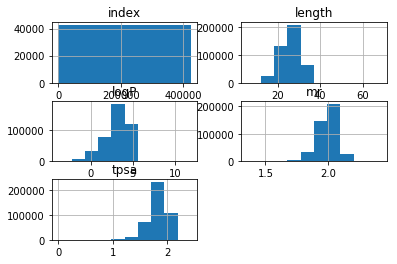

In [72]:
print(train_dataloader.dataset.data.hist())

In [73]:
result = experiment(train_dataloader, args)

encoder 2442385
classifier 64015
logP 131585
mr 131585
tpsa 131585
0.5732572078704834 tensor(23.6155, device='cuda:0', grad_fn=<AddBackward0>)
0.08725333213806152 tensor(64.8558, device='cuda:0', grad_fn=<AddBackward0>)
0.08243489265441895 tensor(19.1111, device='cuda:0', grad_fn=<AddBackward0>)
0.0814046859741211 tensor(20.0015, device='cuda:0', grad_fn=<AddBackward0>)
0.08607745170593262 tensor(22.8063, device='cuda:0', grad_fn=<AddBackward0>)
0.0890200138092041 tensor(26.6114, device='cuda:0', grad_fn=<AddBackward0>)
0.0863807201385498 tensor(17.2903, device='cuda:0', grad_fn=<AddBackward0>)
0.08719348907470703 tensor(16.2195, device='cuda:0', grad_fn=<AddBackward0>)
0.08464670181274414 tensor(20.7388, device='cuda:0', grad_fn=<AddBackward0>)
0.08433723449707031 tensor(27.9163, device='cuda:0', grad_fn=<AddBackward0>)
start validation
logP tensor(1.2982, device='cuda:0')
mr tensor(0.1813, device='cuda:0')
tpsa tensor(0.3142, device='cuda:0')
0.450620174407959 tensor(9.2434, device='

NameError: name 'val_loss' is not defined

In [68]:
import math
df = pd.DataFrame([[1,0.10000001,3], [2,100,10], [3,4,5]], columns=['a', 'b', 'c'])
print(df)
# df['b'] = (df['b']-df['b'].min())/(df['b'].max()-df['b'].min())
df['b'] = np.log10(df['b']+1)
print(df)

   a      b   c
0  1    0.1   3
1  2  100.0  10
2  3    4.0   5
   a         b   c
0  1  0.041393   3
1  2  2.004321  10
2  3  0.698970   5
